# Comparing Networks

In [1]:
#Setup packages etc
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
os.environ['CUDA_VISIBLE_DEVICES']='3'
import pickle
import bz2
import itertools
import pandas as pd
import numpy as np
import scipy as sp
import matplotlib
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from tools.detector import Detector
from tools.readpandas import Get_Momentum

#from trackml.dataset import load_event, load_dataset
import keras
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Flatten
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras import backend as K
from keras.models import load_model
import sklearn.metrics as mt
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
#############################################################
###                                                       ###
###           my functions                                ### 
############################################################
#convert truth direction to local coordinate frame, used to prepare training data
detector = Detector('training_data/detectors.csv')

def truthmom_to_uvw(a):
    b = detector.GlobalToLocalMom(a[1], a[2], a[3], volid, a[4], a[5])
    norm = np.linalg.norm(b)
    return [b[0], b[1], b[2]]/norm


######################
## given a NN predict the directions
#######################
def my_norm(x):
    return (x/np.linalg.norm(x,axis=1)[:,np.newaxis])

def predicteddirections(NNmodel, data):
    temp = NNmodel.predict(data)
    temp = my_norm(temp)
    return temp

##################
### plot an individual hit (jj = 0,1 for two choices of where to start vector arrows--head or tail)
###################
def plot_a_hit(hit_to_plot, NNmodel,jj):
    lw=1
    hitpattern = hit_to_plot[-8:]
    print(hitpattern)
    truedirection = truthmom_to_uvw(hit_to_plot)
    predicteddirection = predicteddirections(NNmodel, np.reshape(hitpattern,(1,8)))[0]
    print(predicteddirection)
    xs=np.array([hitpattern[0],hitpattern[3]])  #x vals of hit
    ys=np.array([hitpattern[1],hitpattern[4]]) #y vals of hit
    ss = np.array([50*hitpattern[2]/(hitpattern[2] + hitpattern[5]),50*hitpattern[5]/(hitpattern[2] + hitpattern[5])])
    fig = plt.figure(figsize=(12,6))
    ax = fig.add_subplot(1, 2, 1)
    ax.scatter(xs, ys, s=ss)
    line=matplotlib.lines.Line2D([xs[0],xs[0]+truedirection[0]],[ys[0],ys[0]+truedirection[1]])
    ax.add_line(line)
    veclength = 1*np.sqrt((xs.max() - xs.min())**2 + (ys.max() - ys.min())**2)
    ax = fig.add_subplot(1, 2, 2, projection='3d')
    ax.set_zlim([-10,10])
    ax.quiver(xs[jj], ys[jj], 0, truedirection[0], truedirection[1], truedirection[2], length=veclength, normalize=True, color='g',linewidth=lw)
    ax.quiver(xs[jj], ys[jj], 0, predicteddirection[0], predicteddirection[1], predicteddirection[2], length=veclength, normalize=True, color='r',linestyle="--",linewidth=lw)
    ax.scatter(xs, ys, np.zeros(2), s=ss)
    fig.show()
    print("vetors (true, predicted)\n", truedirection,"\n", predicteddirection)
#    print("cosine of angle between = ",csine,"   angle = ", np.arccos(csine)*180/np.pi," degrees")
    return

Using TensorFlow backend.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/opt/anaconda3/envs/shared_env/l

In [2]:
x = np.load('x_array.npy')
y = np.load('y_array.npy')

In [3]:
x_xyz = x[:,:3]
x_cluster = x[:,3:]

In [4]:
x_train, x_test, y_train, y_test = train_test_split (x, y, test_size=0.25, random_state=67)
x_xyz_train, x_xyz_test, y_train, y_test = train_test_split (x_xyz, y, test_size=0.25, random_state=67)
x_cluster_train, x_cluster_test, y_train, y_test = train_test_split (x_cluster, y, test_size=0.25, random_state=67)

In [8]:
def build_model(x, y):
    model = Sequential()
    model.add(Dense(units=256, input_dim=x.shape[1]))
    model.add(Activation('relu'))
    model.add(Dense(units=128))
    model.add(Activation('relu'))
    model.add(Dense(units=64))
    model.add(Activation('relu'))
    model.add(Dense(units=32))
    model.add(Activation('relu'))
    model.add(Dense(units=y.shape[1]))       
    model.compile(optimizer='adam', loss='mse', metrics=['accuracy'])
    
    return model

model_total = build_model(x_train, y_train)
model_xyz = build_model(x_xyz_train, y_train)
model_cluster = build_model(x_cluster_train, y_train)

In [9]:
model_total.load_weights('trained_parameters/Direction_predictor_total_200_CP.h5')
model_xyz.load_weights('trained_parameters/Direction_predictor_xyz_200_CP.h5')
model_cluster.load_weights('trained_parameters/Direction_predictor_cluster_200_CP.h5')

In [17]:
def generate_data(model, x, y):
    predicted = predicteddirections(model, x)
    cosines = np.sum(predicted*y, axis=1)
    
    return cosines

In [20]:
data_total = generate_data(model_total, x, y)
data_xyz = generate_data(model_xyz, x_xyz, y)
data_cluster = generate_data(model_cluster, x_cluster, y)

In [21]:
data_total.shape

(7222521,)

In [43]:
np.save('Results/single_total.npy', data_total)
np.save('Results/single_xyz.npy', data_xyz)
np.save('Results/single_cluster.npy', data_cluster)

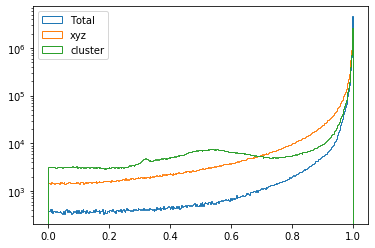

In [42]:
plt.hist(np.abs(data_total), bins=np.linspace(0, 1, 400), label='Total', fill=False, histtype='step')
plt.hist(np.abs(data_xyz), bins=np.linspace(0, 1, 400), label='xyz', fill=False, histtype='step')
plt.hist(np.abs(data_cluster), bins=np.linspace(0, 1, 400), label='cluster', fill=False, histtype='step')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

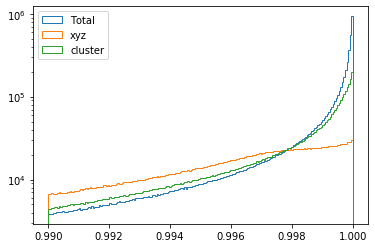

In [40]:
plt.hist(np.abs(data_total), bins=np.linspace(0.99, 1, 200), label='Total', fill=False, histtype='step')
plt.hist(np.abs(data_xyz), bins=np.linspace(0.99, 1, 200), label='xyz', fill=False, histtype='step')
plt.hist(np.abs(data_cluster), bins=np.linspace(0.99, 1, 200), label='cluster', fill=False, histtype='step')
plt.legend(loc='upper left')
plt.yscale('log')
plt.show()

In [54]:
events_layer2 = pd.read_hdf('events_100_table.h5','events',where=('volume_id == 8 & particle_id != 0 & layer_id == 2'))

In [56]:
events_layer4 = pd.read_hdf('events_100_table.h5','events',where=('volume_id == 8 & particle_id != 0 & layer_id == 4'))

In [149]:
# Function to find all possible next hits and the angle to it
def possible_hits(next_layer, current, model, mode):
    """ 
    Function that is used to calculate all the points that lie within a cone with opening angle theta of the current
    hit in the next layer up.
    Input:
        - next_layer: All the hits on the next layer in the form of a database containing at least x, y, z locations
        - current: The current hit in the form of a database containing at least x, y, z and the information to predict the momentum direction
        - theta: Angle that the proposed hit can lie in and still be accepted
    Return:
        - hits: A dataframe, containing the proposed hits with the information from next_layer 
                plus the angle between the current hit and the proposed hit
    """
    # Calculate the hit direction
    hits_direction = (next_layer[['x','y','z']].values-current[['x','y','z']].values)
    hits_direction = hits_direction/np.linalg.norm(hits_direction,axis=1,keepdims=True)
    
    # Obtain the prediction for the direction of the next hit
    if(mode == 'total'):
        model_input = current[['x','y','z','ch0_i','ch1_i','charge_i','ch0_f','ch1_f','charge_f','nch0','nch1']]
    elif(mode == 'xyz'):
        model_input = current[['x', 'y', 'z']]
    else:
        model_input = current[['ch0_i','ch1_i','charge_i','ch0_f','ch1_f','charge_f','nch0','nch1']]
    predicted_direction = predicteddirections(model, model_input).flatten()
    u ,v, w = predicted_direction
    volid, layer_id, module_id = current[['volume_id','layer_id','module_id']].values[0]
    predicted_direction= detector.LocalToGlobalMom(u, v, w, volid,layer_id,module_id)
    
    # Calculate the angle and store into the dataframe
    angle = np.arccos(hits_direction.dot(predicted_direction))
    angle = np.where(angle > np.pi/2, np.pi-angle, angle)
    
    next_layer.loc[:,'angle'] = angle
    return next_layer

In [117]:
events_layer2[(events_layer2['particle_id'] == 837675509285388288) & (events_layer2['event_id'] == '1002')]

,event_id,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tpx,tpy,tpz,ch0_i,ch1_i,ch0_f,ch1_f,charge_i,charge_f,nch0,nch1
21972,1002,21973,6.94672,31.0975,33.210602,8,2,124,837675509285388288,0.033304,0.189374,0.081406,153.0,607.0,152.0,608.0,0.010171,0.112265,2.0,2.0


In [118]:
current_hit = events_layer2[(events_layer2['particle_id'] == 837675509285388288) & (events_layer2['event_id'] == '1002')]
next_layer = events_layer4[events_layer4['event_id'] == '1002']

hits = possible_hits(next_layer, current_hit, model_total, 'total')

[[-0.17091589 -0.07205202 -0.9826476 ]
 [-0.17157063 -0.07176293 -0.9825546 ]
 [-0.14741309 -0.07870539 -0.9859385 ]
 ...
 [-0.18032482 -0.05993349  0.9817795 ]
 [-0.1733787  -0.07043694  0.9823332 ]
 [-0.18220843 -0.07296408  0.98054904]]


In [119]:
hits

,event_id,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tpx,...,tpz,ch0_i,ch1_i,ch0_f,ch1_f,charge_i,charge_f,nch0,nch1,angle
24754,1002,24755,-72.989998,-2.600960,-426.369995,8,4,1,85572241210736640,-0.392001,...,-2.337740,74.0,1141.0,75.0,1157.0,0.060292,0.001358,2.0,17.0,1.101441
24755,1002,24756,-73.047997,-2.361930,-424.904999,8,4,1,153123280683794432,-0.202144,...,-0.727464,70.0,1170.0,70.0,1179.0,0.041846,0.049730,1.0,10.0,1.101631
24756,1002,24757,-71.059799,-10.551000,-488.518005,8,4,1,157652443956510720,-0.923453,...,-5.946950,238.0,35.0,239.0,52.0,0.017544,0.037535,2.0,18.0,1.098448
24758,1002,24759,-68.004204,-23.417999,-455.351013,8,4,2,797147304527134720,-1.598610,...,-11.129900,221.0,624.0,222.0,642.0,0.008242,0.023398,2.0,19.0,1.067176
24759,1002,24760,-69.444603,-20.314400,-471.839996,8,4,2,788136875456987136,-0.248335,...,-1.677560,152.0,332.0,153.0,349.0,0.029082,0.014000,2.0,18.0,1.076924
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31889,1002,31890,-71.624901,12.298800,467.704010,8,4,448,864697656805425152,-0.322951,...,2.246730,62.0,856.0,61.0,875.0,0.033038,0.001129,2.0,20.0,1.287138
31890,1002,31891,-71.484596,8.947070,442.242004,8,4,448,869203043139190784,-1.596410,...,9.618170,129.0,405.0,128.0,421.0,0.050732,0.023086,2.0,17.0,1.300159
31891,1002,31892,-71.322899,5.083490,459.350006,8,4,448,54055083997921280,-0.328471,...,1.937700,207.0,709.0,206.0,725.0,0.033195,0.010908,2.0,17.0,1.304659
31893,1002,31894,-71.084900,-0.603672,475.324005,8,4,448,418835383820746752,-0.744661,...,5.352290,320.0,991.0,320.0,1010.0,0.009924,0.050465,1.0,20.0,1.312973


In [130]:
def check_outward(next_layer, current):
    phi = np.arctan2(current['y'], current['x']).item()
    next_layer.loc[:, 'dphi'] = np.abs(np.arctan2(next_layer['y'], next_layer['x']) - phi)
    
    return next_layer[next_layer['dphi'] < np.pi/2]

In [120]:
hits[hits['angle'].min() == hits['angle']]

,event_id,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tpx,...,tpz,ch0_i,ch1_i,ch0_f,ch1_f,charge_i,charge_f,nch0,nch1,angle
27597,1002,27598,-14.5655,-72.215302,-7.04162,8,4,200,288233399808688128,-0.085916,...,-0.549905,17.0,1135.0,18.0,1138.0,0.026011,0.032474,2.0,4.0,0.005985


In [131]:
hits_outward = check_outward(hits, current_hit)

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  


In [132]:
hits[hits['particle_id'] == 837675509285388288]

,event_id,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tpx,...,ch0_i,ch1_i,ch0_f,ch1_f,charge_i,charge_f,nch0,nch1,angle,dphi
29166,1002,29167,10.7364,71.559502,50.017601,8,4,248,837675509285388288,0.005077,...,93.0,906.0,93.0,907.0,0.091219,0.084164,1.0,2.0,0.111654,0.070853


In [133]:
hits_outward[hits_outward['angle'].min() == hits_outward['angle']]

,event_id,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tpx,...,ch0_i,ch1_i,ch0_f,ch1_f,charge_i,charge_f,nch0,nch1,angle,dphi
29116,1002,29117,16.4872,69.336601,52.973301,8,4,247,9010772667531264,0.199019,...,255.0,958.0,255.0,960.0,0.061292,0.06654,1.0,3.0,0.101929,0.013673


In [134]:
hits_outward

,event_id,hit_id,x,y,z,volume_id,layer_id,module_id,particle_id,tpx,...,ch0_i,ch1_i,ch0_f,ch1_f,charge_i,charge_f,nch0,nch1,angle,dphi
24849,1002,24850,70.346100,-13.223400,-476.700989,8,4,15,707084520389607424,0.423792,...,324.0,245.0,324.0,263.0,0.055262,0.017794,1.0,19.0,1.148559,1.536827
24851,1002,24852,70.108398,-14.749000,-467.937988,8,4,15,878204607396839424,0.251436,...,293.0,403.0,294.0,416.0,0.050290,0.041202,2.0,14.0,1.144676,1.558370
24855,1002,24856,72.112701,-12.113200,-489.140991,8,4,16,342295768071143424,0.550387,...,66.0,24.0,67.0,41.0,0.046137,0.033811,2.0,18.0,1.152662,1.517442
24856,1002,24857,71.926399,-7.662970,-449.451996,8,4,16,166634698041196544,0.505455,...,155.0,731.0,156.0,745.0,0.019943,0.043220,2.0,15.0,1.157595,1.457158
24857,1002,24858,72.248802,-15.367100,-479.252014,8,4,16,878204607396839424,0.251562,...,0.0,201.0,2.0,215.0,0.000480,0.052095,3.0,15.0,1.145822,1.560593
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31881,1002,31882,-68.153099,24.084900,450.341003,8,4,447,788130347106697216,-0.249981,...,102.0,548.0,101.0,566.0,0.031394,0.007199,2.0,19.0,1.261875,1.450878
31882,1002,31883,-68.132103,24.220100,463.635010,8,4,447,707068165154144256,-0.575933,...,99.0,785.0,98.0,802.0,0.051683,0.008276,2.0,18.0,1.259644,1.449018
31883,1002,31884,-69.183197,17.472099,469.277008,8,4,447,612491404748259328,-1.453070,...,236.0,885.0,235.0,902.0,0.046710,0.030272,2.0,18.0,1.274173,1.543198
31884,1002,31885,-68.859497,19.550200,470.223999,8,4,447,40538993716101120,-0.610166,...,193.0,900.0,193.0,920.0,0.016808,0.027802,1.0,21.0,1.269312,1.513938


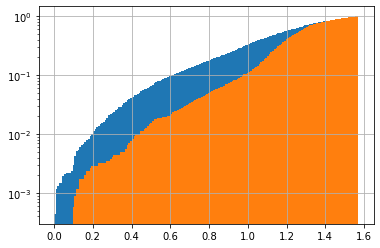

In [138]:
angles = np.linspace(0, np.pi/2, 181)
hits['angle'].hist(cumulative=True, weights=1.0/len(next_layer)*np.ones_like(hits['angle']), bins=angles)
hits_outward['angle'].hist(cumulative=True, weights=1.0/len(hits_outward)*np.ones_like(hits_outward['angle']), bins=angles)
plt.yscale('log')
plt.show()

In [181]:
def make_roc(layer2, layer4, model, mode):
    angles = np.linspace(0, np.pi/2, 181)
    all_next = np.array([])
    
    all_hits = np.zeros_like(angles)[:-1]
    all_outward = np.zeros_like(all_hits)
    
    for hit in layer2['hit_id'].values:
        current_hit = layer2[layer2['hit_id'] == hit]
        next_hit = layer4[layer4['particle_id'] == current_hit['particle_id'].item()]
        if(len(next_hit) == 0 or current_hit['particle_id'].item() == 0):
            continue
        next_hit_id = next_hit['hit_id'].values[0]
        
        # total
        hits = possible_hits(layer4, current_hit, model, mode)
        hits_outward = check_outward(hits, current_hit)
        
        hist, bins = np.histogram(hits['angle'], bins=angles)
        all_hits += np.cumsum(hist/len(hits))
        
        hist, bins = np.histogram(hits_outward['angle'], bins=angles)
        all_outward += np.cumsum(hist/len(hits_outward))
        
        all_next = np.append(all_next, hits[hits['hit_id'] == next_hit_id]['angle'].item())
        
        
    return all_hits, all_outward, all_next

In [182]:
layer2 = events_layer2[events_layer2['event_id'] == '1002']
layer4 = events_layer4[events_layer4['event_id'] == '1002']

total = make_roc(layer2, layer4, model_total, 'total')
xyz = make_roc(layer2, layer4, model_xyz, 'xyz')
cluster = make_roc(layer2, layer4, model_cluster, 'cluster')

/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `item` has been deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `item` has been deprecated and will be removed in a future version
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:

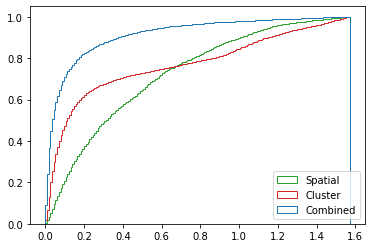

In [186]:
plt.hist(xyz[2], histtype='step', bins=angles, density=True, cumulative=True, color='tab:green', label='Spatial')
plt.hist(cluster[2], histtype='step', bins=angles, density=True, cumulative=True, color='tab:red', label='Cluster')
plt.hist(total[2], histtype='step', bins=angles, density=True, cumulative=True, color='tab:blue', label='Combined')
plt.legend(loc="lower right")
plt.show()

In [198]:
total_next, _ = np.histogram(total[2], bins=angles)
total_next = np.cumsum(total_next)/len(total[2])

xyz_next, _ = np.histogram(xyz[2], bins=angles)
xyz_next = np.cumsum(xyz_next)/len(xyz[2])

cluster_next, _ = np.histogram(cluster[2], bins=angles)
cluster_next = np.cumsum(cluster_next)/len(cluster[2])

(0.09, 1.1)

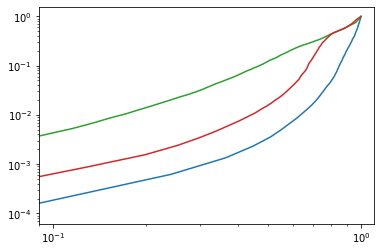

In [196]:
plt.plot(total_next, total[0]/len(total[2]), color='tab:blue')
plt.plot(xyz_next, xyz[0]/len(xyz[2]), color='tab:green')
plt.plot(cluster_next, cluster[0]/len(cluster[2]), color='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.09, 1.1])

(0.09, 1.1)

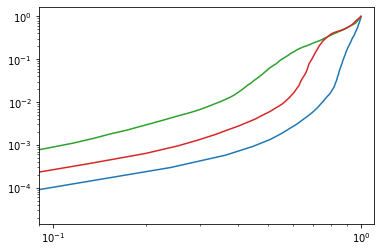

In [197]:
plt.plot(total_next, total[1]/len(total[2]), color='tab:blue')
plt.plot(xyz_next, xyz[1]/len(xyz[2]), color='tab:green')
plt.plot(cluster_next, cluster[1]/len(cluster[2]), color='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.09, 1.1])

In [200]:
all_events = events_layer2['event_id'].unique()
total = []
xyz = []
cluster = []

for event_id in all_events:
    print(event_id)
    layer2 = events_layer2[events_layer2['event_id'] == event_id]
    layer4 = events_layer4[events_layer4['event_id'] == event_id]
    
    total.append(make_roc(layer2, layer4, model_total, 'total'))
    xyz.append(make_roc(layer2, layer4, model_xyz, 'xyz'))
    cluster.append(make_roc(layer2, layer4, model_cluster, 'cluster'))

1000


/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:10: FutureWarning: `item` has been deprecated and will be removed in a future version
  # Remove the CWD from sys.path while we load stuff.
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:11: FutureWarning: `item` has been deprecated and will be removed in a future version
  # This is added back by InteractiveShellApp.init_path()
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: `item` has been deprecated and will be removed in a future version
  
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:25: FutureWarning: `item` has been deprecated and will be removed in a future version
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in arccos
/opt/anaconda3/envs/shared_env/lib/python3.6/site-packages/ipykernel_launcher.py:

1001
1002
1003
1004
1005
1006
1007
1008
1009
1010
1011
1012
1013
1014
1015
1016
1017
1018
1019
1020
1021
1022
1023
1024
1025
1026
1027
1028
1029
1030
1031
1032
1033
1034
1035
1036
1037
1038
1039
1040
1041
1042
1043
1044
1045
1046
1047
1048
1049
1050
1051
1052
1053
1054
1055
1056
1057
1058
1059
1060
1061
1062
1063
1064
1065
1066
1067
1068
1069
1070
1071
1072
1073
1074
1075
1076
1077
1078
1079
1080
1081
1082
1083
1084
1085
1086
1087
1088
1089
1090
1091
1092
1093
1094
1095
1096
1097
1098
1099


In [222]:
total_prob = []
total_frac = []
total_frac_out = []

for result in total:
    total_next, _ = np.histogram(result[2], bins=angles)
    total_next = np.cumsum(total_next)/len(result[2])
    total_prob.append(total_next)
    total_frac.append(result[0])
    total_frac_out.append(result[1])

total_prob = np.mean(np.array(total_prob), axis=0)
total_frac = np.mean(np.array(total_frac), axis=0)
total_frac_out = np.mean(np.array(total_frac_out), axis=0)

In [225]:
xyz_prob = []
xyz_frac = []
xyz_frac_out = []

for result in xyz:
    xyz_next, _ = np.histogram(result[2], bins=angles)
    xyz_next = np.cumsum(xyz_next)/len(result[2])
    xyz_prob.append(xyz_next)
    xyz_frac.append(result[0])
    xyz_frac_out.append(result[1])

xyz_prob = np.mean(np.array(xyz_prob), axis=0)
xyz_frac = np.mean(np.array(xyz_frac), axis=0)
xyz_frac_out = np.mean(np.array(xyz_frac_out), axis=0)

In [228]:
cluster_prob = []
cluster_frac = []
cluster_frac_out = []

for result in cluster:
    cluster_next, _ = np.histogram(result[2], bins=angles)
    cluster_next = np.cumsum(cluster_next)/len(result[2])
    cluster_prob.append(cluster_next)
    cluster_frac.append(result[0])
    cluster_frac_out.append(result[1])

cluster_prob = np.mean(np.array(cluster_prob), axis=0)
cluster_frac = np.mean(np.array(cluster_frac), axis=0)
cluster_frac_out = np.mean(np.array(cluster_frac_out), axis=0)

(0.09, 1.1)

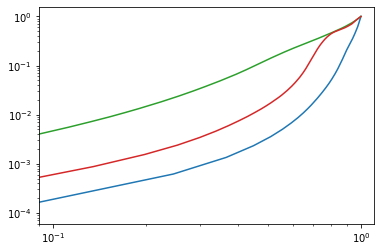

In [229]:
plt.plot(total_prob, total_frac/total_frac[-1], color='tab:blue')
plt.plot(xyz_prob, xyz_frac/xyz_frac[-1], color='tab:green')
plt.plot(cluster_prob, cluster_frac/cluster_frac[-1], color='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.09, 1.1])

(0.09, 1.1)

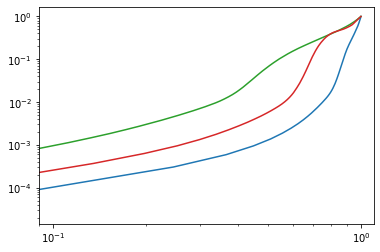

In [230]:
plt.plot(total_prob, total_frac_out/total_frac[-1], color='tab:blue')
plt.plot(xyz_prob, xyz_frac_out/xyz_frac[-1], color='tab:green')
plt.plot(cluster_prob, cluster_frac_out/cluster_frac[-1], color='tab:red')
plt.yscale('log')
plt.xscale('log')
plt.xlim([0.09, 1.1])

In [231]:
np.save('Results/singlet_total_prob.npy', total_prob)
np.save('Results/singlet_total_frac.npy', total_frac)
np.save('Results/singley_total_frac_out.npy', total_frac_out)

np.save('Results/singlet_xyz_prob.npy', xyz_prob)
np.save('Results/singlet_xyz_frac.npy', xyz_frac)
np.save('Results/singley_xyz_frac_out.npy', xyz_frac_out)

np.save('Results/singlet_cluster_prob.npy', cluster_prob)
np.save('Results/singlet_cluster_frac.npy', cluster_frac)
np.save('Results/singley_cluster_frac_out.npy', cluster_frac_out)